In [1]:
%pylab inline
import calin.calib.spe_fit
import calin.math.histogram
import calin.math.optimizer
import calin.math.pdf_1d

Populating the interactive namespace from numpy and matplotlib


In [2]:
fernandez_data = loadtxt('../../calib/fernandez_dc_1.5kV_6.45V.dat');
mes_hist = calin.math.histogram.SimpleHist(1.0)
mes_hist.insert_vec(fernandez_data);

In [3]:
mes_model_gauss = calin.calib.spe_fit.PoissonGaussianMES(20)
like_gauss = calin.calib.spe_fit.SPELikelihood(mes_model_gauss, mes_hist)
opt_gauss = calin.math.optimizer.NLOptOptimizer(calin.math.optimizer.LD_LBFGS, like_gauss)
opt_gauss.set_scale([0.1,0.1,1.0,1.0,0.05]);
opt_gauss.set_verbosity_level(calin.math.optimizer.OptimizerVerbosityLevel_MAX);
opt_gauss.set_abs_tolerance(0.0001);
opt_gauss.set_initial_values([1.0, 355.0, 50.0, 500.0, 0.4]);
status, xopt_gauss, fval_gauss = opt_gauss.minimize()
print(xopt_gauss, fval_gauss)
#xopt_gauss = asarray([1.0, 355.0, 50.0, 500.0, 0.4])
status, err_mat_gauss = opt_gauss.calc_error_matrix()
xerr_gauss = sqrt(err_mat_gauss.diagonal())
print(xerr_gauss)

[  1.06383228e+00   3.58333554e+02   4.95838946e+01   4.49387984e+02
   3.86590583e-01] 72514.7983248876
[ 0.01423682  0.97761588  0.87447863  4.32673625  0.01166508]


In [4]:
ses_exp_pdf = calin.math.pdf_1d.LimitedExponentialPDF(0,numpy.inf,mes_hist.dxval())
ses_exp_pdf.limit_scale(0.1, inf);
ses_gauss_pdf = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
ses_two_cpt = calin.math.pdf_1d.TwoComponentPDF(ses_exp_pdf, "exp", ses_gauss_pdf, "gauss")
ped_gauss_pdf = calin.math.pdf_1d.GaussianPDF()
mes_model_two_cpt = calin.calib.spe_fit.GeneralPoissonMES(mes_hist.xval_left(0), mes_hist.dxval(),\
        mes_hist.size(), ses_two_cpt, ped_gauss_pdf)
like_two_cpt = calin.calib.spe_fit.SPELikelihood(mes_model_two_cpt, mes_hist)
opt_two_cpt = calin.math.optimizer.NLOptOptimizer(calin.math.optimizer.LD_LBFGS, like_two_cpt)
#opt_two_cpt.set_scale([0.1,0.1,1.0,0.01,1.0,1.0,0.05]);
opt_two_cpt.set_verbosity_level(calin.math.optimizer.OptimizerVerbosityLevel_MAX);
opt_two_cpt.set_abs_tolerance(0.001);
opt_two_cpt.set_initial_values([1.0, 355.0, 10.0, 0.2, 100.0, 500.0, 200.0]);
status, xopt_two_cpt, fval_two_cpt = opt_two_cpt.minimize()
print(status, xopt_two_cpt, fval_two_cpt)

status, err_mat_two_cpt = opt_two_cpt.calc_error_matrix()
xerr_two_cpt = sqrt(err_mat_two_cpt.diagonal())
print(xerr_two_cpt)

False [  1.29314527e+00   3.49235491e+02   4.57846109e+01   2.75079186e-01
   9.76067593e+01   4.84561548e+02   1.31671206e+02] 72470.98135720298
[  0.04087411   1.53635734   0.92585793   0.0214064   17.28982614
   4.61462549   4.59456954]


In [5]:
ses_2g_pdf_a = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
ses_2g_pdf_b = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
ses_2g_cpt = calin.math.pdf_1d.TwoComponentPDF(ses_2g_pdf_a, "g1", ses_2g_pdf_b, "g2")
ped_2g_pdf = calin.math.pdf_1d.GaussianPDF()
mes_model_2g_cpt = calin.calib.spe_fit.GeneralPoissonMES(mes_hist.xval_left(0), mes_hist.dxval(),\
        mes_hist.size(), ses_2g_cpt, ped_2g_pdf)
like_2g_cpt = calin.calib.spe_fit.SPELikelihood(mes_model_2g_cpt, mes_hist)
freezer = calin.math.function.FreezeThawFunction(like_2g_cpt)
freezer.freeze(4,0)
opt_2g_cpt = calin.math.optimizer.NLOptOptimizer(calin.math.optimizer.LD_LBFGS, freezer)
#opt_two_cpt.set_scale([0.1,0.1,1.0,0.01,1.0,1.0,0.05]);
opt_2g_cpt.set_verbosity_level(calin.math.optimizer.OptimizerVerbosityLevel_MAX);
opt_2g_cpt.set_abs_tolerance(0.001);
opt_2g_cpt.set_initial_values([1.0, 355.0, 10.0, 0.2, 100.0, 500.0, 200.0]);
status, xopt_2g_cpt, fval_2g_cpt = opt_2g_cpt.minimize()
print(status, xopt_2g_cpt, fval_2g_cpt)


False [  1.26253390e+00   3.49630123e+02   4.58387932e+01   2.26511573e-01
   9.83266518e+01   4.77252064e+02   1.38047412e+02] 72474.44817726241


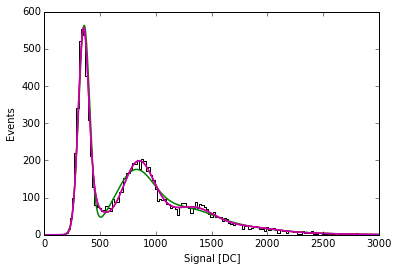

In [6]:
mes_hist_plot = calin.math.histogram.SimpleHist(20.0)
mes_hist_plot.insert_vec(fernandez_data);

ihist = range(0,mes_hist_plot.nbin());
xhist_plot = list(map(lambda i: mes_hist_plot.xval_center(i),ihist))
yhist_plot = list(map(lambda i: mes_hist_plot.weight(i),ihist))
step(xhist_plot,yhist_plot,'k')
xlabel('Signal [DC]')
ylabel('Events')

ihist = range(0,mes_hist.nbin());
xhist = list(map(lambda i: mes_hist.xval_center(i),ihist))

mes_model_gauss.set_parameter_values(xopt_gauss)
ymodel_gauss = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_gauss.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_gauss,'g',lw=1.5)

mes_model_two_cpt.set_parameter_values(xopt_two_cpt)
ymodel_two_cpt = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_two_cpt.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_two_cpt,'r',lw=1.5)

mes_model_2g_cpt.set_parameter_values(freezer.x_in2out(xopt_2g_cpt))
ymodel_2g_cpt = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_two_cpt.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_2g_cpt,'m',lw=1.5)

axis([0,3000,0,600])
gcf().savefig('../../../mybuild/spe_two_cpt.pdf')

In [7]:
err_mat_ses = mes_model_two_cpt.extract_ses_hessian_values(err_mat_two_cpt)
print(err_mat_ses)

[[  4.58233954e-04  -4.00150686e-02   2.88158705e-02  -4.25886924e-02]
 [ -4.00150686e-02   2.98938088e+02   4.82259282e+01  -4.51037315e+01]
 [  2.88158705e-02   4.82259282e+01   2.12947684e+01  -1.07032527e+01]
 [ -4.25886924e-02  -4.51037315e+01  -1.07032527e+01   2.11100692e+01]]


[0, 1500, 0, 0.003]

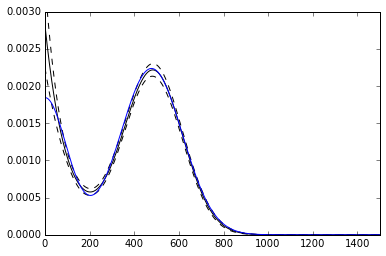

In [15]:
ses_y = asarray(mes_model_two_cpt.n_electron_spectrum(1));
ses_x = ses_y*0;
ses_dy = ses_y*0;
for i in range(0,len(ses_y)):
    ses_x[i] = mes_model_two_cpt.ses_x(i)
    val, grad = ses_two_cpt.value_and_parameter_gradient_1d(ses_x[i])
    grad = reshape(grad,(4,1))
    ses_dy[i] = sqrt(grad.transpose()*matrix(err_mat_ses)*grad)
plot(ses_x, ses_y, 'k', ses_x, ses_y+ses_dy,'k--',ses_y-ses_dy,'k--')
ses_2g_y = asarray(mes_model_2g_cpt.n_electron_spectrum(1));
ses_2g_x = ses_y*0;
for i in range(0,len(ses_y)):
    ses_2g_x[i] = mes_model_two_cpt.ses_x(i)
plot(ses_2g_x, ses_2g_y, 'b')

axis([0,1500,0,0.003])

In [16]:
ses_norm = sum(ses_y)
ses_mean = sum(ses_y*ses_x)
ses_rms = sqrt(sum(ses_y*ses_x*ses_x) - ses_mean**2)
print(ses_norm, ses_mean, ses_rms)
print(ses_rms/ses_mean)
print(sqrt(1+(ses_rms/ses_mean)**2))

1.00000000293 378.162216664 212.215491914
0.561175819697
1.14669887094


In [17]:
ses_2g_norm = sum(ses_2g_y)
ses_2g_mean = sum(ses_2g_y*ses_2g_x)
ses_2g_rms = sqrt(sum(ses_2g_y*ses_2g_x*ses_2g_x) - ses_2g_mean**2)
print(ses_2g_norm, ses_2g_mean, ses_2g_rms)
print(ses_2g_rms/ses_2g_mean)
print(sqrt(1+(ses_2g_rms/ses_2g_mean)**2))

1.00000000592 387.027796086 208.251278955
0.538078352669
1.13557400182
